In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.append("..")

import tensorflow as tf
import keras
from keras import layers
import kerastuner as kt

/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_34737/599092196.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [3]:
'''data = pd.read_csv("../dp03/dp03_objects.csv")

# Clean

clean_objs = data.dropna()
clean_objs = clean_objs.drop(columns=["ssObjectId", "fullDesignation", "q2", "e2", "Unnamed: 0"])

clean_objs["i-z"] = clean_objs["i_H"] - clean_objs["z_H"]
clean_objs["g-r"] = clean_objs["g_H"] - clean_objs["r_H"]
clean_objs["r-i"] = clean_objs["r_H"] - clean_objs["i_H"]


clean_objs["a*"] = .89*(clean_objs["g-r"]) + .45*(clean_objs["r-i"]) -.57

clean_objs["a"] = clean_objs["q"]/(1-clean_objs["e"])

clean_objs["Q"] = clean_objs["a"]*(1 + clean_objs["e"])
clean_objs["T_jup"] = (5.204/clean_objs["a"]) + 2*np.cos((clean_objs["incl"]/180)*np.pi)*np.sqrt((clean_objs["a"]/5.204)*(1 - clean_objs["e"]**2))

X = clean_objs.to_numpy()

# Pre-processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

pipe = Pipeline([('ss_scaler', StandardScaler()), ('mm_scaler', MinMaxScaler())])

pipe.fit(X)'''

# split into 80:10:10

'''X_train, X_test = train_test_split(
    pipe.transform(X),
    test_size=.1,
    random_state = 42
)
X_train, X_valid = train_test_split(
    X_train,
    test_size=.111,
    random_state = 42
)'''

X_train = np.load("X_train.npy")
X_valid = np.load("X_valid.npy")
X_test = np.load("X_test.npy")

In [6]:
# Autoencoder class

class AE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:

            z = self.encoder(data)

            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum((data - reconstruction)**2, axis=0))

            total_loss = reconstruction_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)


        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        }
    def test_step(self, data):

        z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum((data - reconstruction)**2, axis=0))


        total_loss = reconstruction_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        }

def build_model(hp):
    input_dim = len(X_train[0])

    neurons_first_layer = hp.Int(
      "first_layer",
      min_value=64,
      max_value=128
    )
    
    neurons_second_layer = hp.Int(
      "second_layer",
      min_value=32,
      max_value=64
    )
    neurons_third_layer = hp.Int(
      "third_layer",
      min_value=16,
      max_value=32
    )


    encoder_inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(
       neurons_first_layer
    )(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x, max_value=1, threshold=0.0)
    x = layers.Dense(
        neurons_second_layer
    )(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x, max_value=1, threshold=0.0)
    x = layers.Dense(
        neurons_third_layer
    )(x)

    z = layers.Dense(latent_dim, name="z")(x)
    encoder = keras.Model(encoder_inputs, z, name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim))

    x = layers.Dense(
        neurons_third_layer
    )(latent_inputs)
    x = tf.keras.activations.relu(x, max_value=1, threshold=0.0)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(
        neurons_second_layer
    )(x)
    x = tf.keras.activations.relu(x, max_value=1, threshold=0.0)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(
        neurons_first_layer
    )(x)

    decoder_outputs = layers.Dense(input_dim, activation="sigmoid")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    ae = AE(encoder, decoder)

    ae.compile(optimizer=keras.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4]),
    ), run_eagerly=True)

    return ae

def latent_model(ld):
    global latent_dim
    latent_dim = ld
    return build_model

In [8]:
def create_tuner(ld, overwrite=False):
    tuner = kt.BayesianOptimization(
        hypermodel=latent_model(ld=ld),
        objective="val_loss",
        max_trials=5,
        executions_per_trial=1,
        overwrite=overwrite,
        directory=f"./tuner/ld_{ld}",
        project_name="tuner_results",
    )
    return tuner


In [6]:
for i in range(4,12,2):
    print(f"Starting latent dim {i}")
    tuner = create_tuner(ld = i, overwrite=True)
    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, min_delta=0.01)
    ]
    tuner.search(X_train, validation_data=(X_valid,), batch_size=1024, epochs=10, callbacks=callbacks)
    print("------")

Trial 5 Complete [00h 03m 45s]
val_loss: 0.10243906825780869

Best val_loss So Far: 0.013891945593059063
Total elapsed time: 00h 31m 15s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


------


In [19]:
'''for i in range(10,12,2):
    print(f"Starting latent dimensions {i}")
    print("-------")
    tuner = create_tuner(i, overwrite=False)
    best_hps = tuner.get_best_hyperparameters(1)

    ae = build_model(best_hps[0])

    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=0.001)
    ]
    ae.fit(
        X_train, validation_data=(X_valid,), batch_size=1024, epochs=100, callbacks=callbacks
    )
    ae.save_weights(f"./weights/ld_{i}/best")

    print(f"Finished latent dimensions {i}")
    print("------")'''

Starting latent dimensions 10
-------
INFO:tensorflow:Reloading Tuner from ./tuner/ld_10/tuner_results/tuner0.json


INFO:tensorflow:Reloading Tuner from ./tuner/ld_10/tuner_results/tuner0.json


Epoch 1/100
2426/2426 [==============================] - 433s 178ms/step - loss: 7.0839 - reconstruction_loss: 1.7284 - val_loss: 0.3335 - val_reconstruction_loss: 0.3335
Epoch 2/100
2426/2426 [==============================] - 1397s 576ms/step - loss: 0.2669 - reconstruction_loss: 0.1791 - val_loss: 0.0988 - val_reconstruction_loss: 0.0988
Epoch 3/100
2426/2426 [==============================] - 54s 22ms/step - loss: 0.0777 - reconstruction_loss: 0.0638 - val_loss: 0.0428 - val_reconstruction_loss: 0.0428
Epoch 4/100
2426/2426 [==============================] - 55s 23ms/step - loss: 0.0426 - reconstruction_loss: 0.0403 - val_loss: 0.0352 - val_reconstruction_loss: 0.0352
Epoch 5/100
2426/2426 [==============================] - 56s 23ms/step - loss: 0.0330 - reconstruction_loss: 0.0289 - val_loss: 0.0288 - val_reconstruction_loss: 0.0288
Epoch 6/100
2426/2426 [==============================] - 55s 22ms/step - loss: 0.0227 - reconstruction_loss: 0.0201 - val_loss: 0.0202 - val_reconstru

#### Full training of 6 component latent space

In [67]:
'''tuner = create_tuner(6, overwrite=False)
best_hps = tuner.get_best_hyperparameters(1)

ae = build_model(best_hps[0])

callbacks = [
    keras.callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True, min_delta=0.001)
]

ae.fit(
    np.concatenate([X_train, X_valid, X_test]), batch_size=1024, epochs=100, callbacks=callbacks
)

ae.save_weights(f"./weights/final/final")'''

INFO:tensorflow:Reloading Tuner from ./tuner/ld_6/tuner_results/tuner0.json


INFO:tensorflow:Reloading Tuner from ./tuner/ld_6/tuner_results/tuner0.json


Epoch 1/100
3032/3032 [==============================] - 71s 23ms/step - loss: 6.4417 - reconstruction_loss: 1.5314
Epoch 2/100
3032/3032 [==============================] - 69s 23ms/step - loss: 0.0981 - reconstruction_loss: 0.0950
Epoch 3/100
3032/3032 [==============================] - 69s 23ms/step - loss: 0.0619 - reconstruction_loss: 0.0528
Epoch 4/100
3032/3032 [==============================] - 69s 23ms/step - loss: 0.0313 - reconstruction_loss: 0.0263
Epoch 5/100
3032/3032 [==============================] - 70s 23ms/step - loss: 0.0236 - reconstruction_loss: 0.0224
Epoch 6/100
3032/3032 [==============================] - 69s 23ms/step - loss: 0.0227 - reconstruction_loss: 0.0208
Epoch 7/100
3032/3032 [==============================] - 69s 23ms/step - loss: 0.0188 - reconstruction_loss: 0.0179
Epoch 8/100
3032/3032 [==============================] - 68s 23ms/step - loss: 0.0166 - reconstruction_loss: 0.0161
Epoch 9/100
3032/3032 [==============================] - 69s 23ms/step -

In [73]:
X_norm = pipe.transform(X)

encoded = ae.encoder.predict(
    X_norm[:10000]
)

decoded = ae.decoder.predict(
    encoded
)

  2/313 [..............................] - ETA: 2:46:10

In [51]:
np.save("normalised_objs", pipe.transform(X))

In [11]:
tuner = create_tuner(6, overwrite=False)
best_hps = tuner.get_best_hyperparameters(1)

ae = build_model(best_hps[0])

callbacks = [
    keras.callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True, min_delta=0.001)
]

ae.load_weights(f"./weights/final/final")

INFO:tensorflow:Reloading Tuner from ./tuner/ld_6/tuner_results/tuner0.json


2023-08-14 20:49:06.381718: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-08-14 20:49:06.382419: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-14 20:49:06.382435: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-14 20:49:06.382795: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-14 20:49:06.383306: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
encoded = ae.encoder.predict(
    pipe.transform(X)
)

97002/97002 [==============================] - 112s 1ms/step


In [15]:
decoded = ae.decoder.predict(
    encoded
)

   87/97002 [..............................] - ETA: 1:54 

2023-08-14 20:57:10.089897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


97002/97002 [==============================] - 107s 1ms/step


In [47]:
np.save("encoded_objs", encoded)
np.save("decoded_objs", decoded)

In [16]:
rl = np.sum((pipe.transform(X) - decoded)**2, axis=1)

In [31]:
list(clean_objs.iloc[np.argsort(rl)[-20::], :].index)

[2374646,
 847605,
 298470,
 120122,
 766713,
 3907178,
 436945,
 3718119,
 615842,
 1038232,
 3938451,
 4344516,
 2748717,
 1369289,
 3361266,
 838704,
 1130166,
 866937,
 2335387,
 1425257]

In [33]:
clean_objs.iloc[np.argsort(rl)[-20::], :].index

Index([2374646,  847605,  298470,  120122,  766713, 3907178,  436945, 3718119,
        615842, 1038232, 3938451, 4344516, 2748717, 1369289, 3361266,  838704,
       1130166,  866937, 2335387, 1425257],
      dtype='int64')

In [36]:
data.iloc[list(clean_objs.iloc[np.argsort(rl)[-40::], :].index), :]

,Unnamed: 0,ssObjectId,fullDesignation,flags,g_Chi2,g_G12,g_G12Err,g_H,g_HErr,i_Chi2,...,q,e,z_H,z_HErr,e2,incl,q2,peri,node,mpcH
4120914,4120914,7890673196960129876,2011 S000181xa,2114,1.415989,-5.085256e+04,1.219847e+10,37.688240,2.638816e+05,2.098607,...,0.022562,0.989960,33.864105,6.125194e+05,0.989960,36.067068,0.022562,107.616365,78.718218,24.969000
3354061,3354061,4706151268845572190,2011 S102vXPca,66,1.059349,-1.241534e+05,6.235090e+10,34.883030,5.531491e+05,1.478520,...,1.873395,0.404732,26.775057,2.203268e+00,0.404732,19.630670,1.873395,114.541570,200.950180,22.860000
3832419,3832419,6691116101522867083,2011 S104yjSCa,2114,0.207869,1.024757e+01,2.092554e+00,24.744644,1.505068e+00,1.043965,...,1.516351,0.377639,38.481970,4.037779e+05,0.377639,20.121420,1.516351,68.383028,288.451110,24.220000
2421084,2421084,839293102145863133,2011 LPCC3860,66,15011.430000,8.528010e-04,7.039094e-03,16.462843,5.402667e-03,4188.957500,...,0.827546,0.995629,15.771560,5.666129e-03,0.995629,161.278282,0.827546,114.227084,234.570288,15.000000
2350558,2350558,546408656443755499,2011 iso0002825,66,0.488144,-2.453214e+00,8.998199e+00,22.748447,2.519668e+00,0.470181,...,2.093283,8.787034,21.459637,1.070696e+01,8.787034,85.433771,2.093283,217.892388,214.719216,20.143877
3738564,3738564,6302496554561793347,2011 1992 SK,66,20668.484000,1.184403e+00,1.312230e-02,17.971697,3.809609e-03,1985.710000,...,0.841882,0.324680,17.038998,2.452256e-03,0.324680,15.321090,0.841882,233.415733,8.901580,17.160000
2897484,2897484,2812021707001146916,2011 S00017Lla,66,0.107448,-1.241319e+06,2.960823e+12,34.588287,2.612291e+06,0.449831,...,1.184986,0.716813,23.134922,2.909711e+00,0.716813,14.674076,1.184986,41.921352,277.117337,24.964000
552449,552449,-6928817950519709082,2011 LPCC3193,66,6.852368,-2.197390e-02,8.795639e-02,15.748229,4.336692e-02,7.169060,...,3.394605,0.994098,15.025770,1.638573e-02,0.994098,164.465107,3.394605,207.664535,242.407732,15.000000
815778,815778,-5835327978714286886,2011 S00018ota,66,0.834549,-1.530924e+05,2.693997e+11,40.777270,1.931589e+06,2.524240,...,1.182876,0.575673,40.488956,1.279448e+06,0.575673,17.903060,1.182876,142.243124,131.266479,24.975000
1684761,1684761,-2216836111790491784,2011 S107Adx1a,2114,5.117446,9.575222e+06,4.438821e+12,37.582886,5.129329e+05,0.888703,...,1.406901,0.699502,24.205100,2.232485e+00,0.699502,10.088850,1.406901,96.238006,198.704940,25.070000


/Users/br/Desktop/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


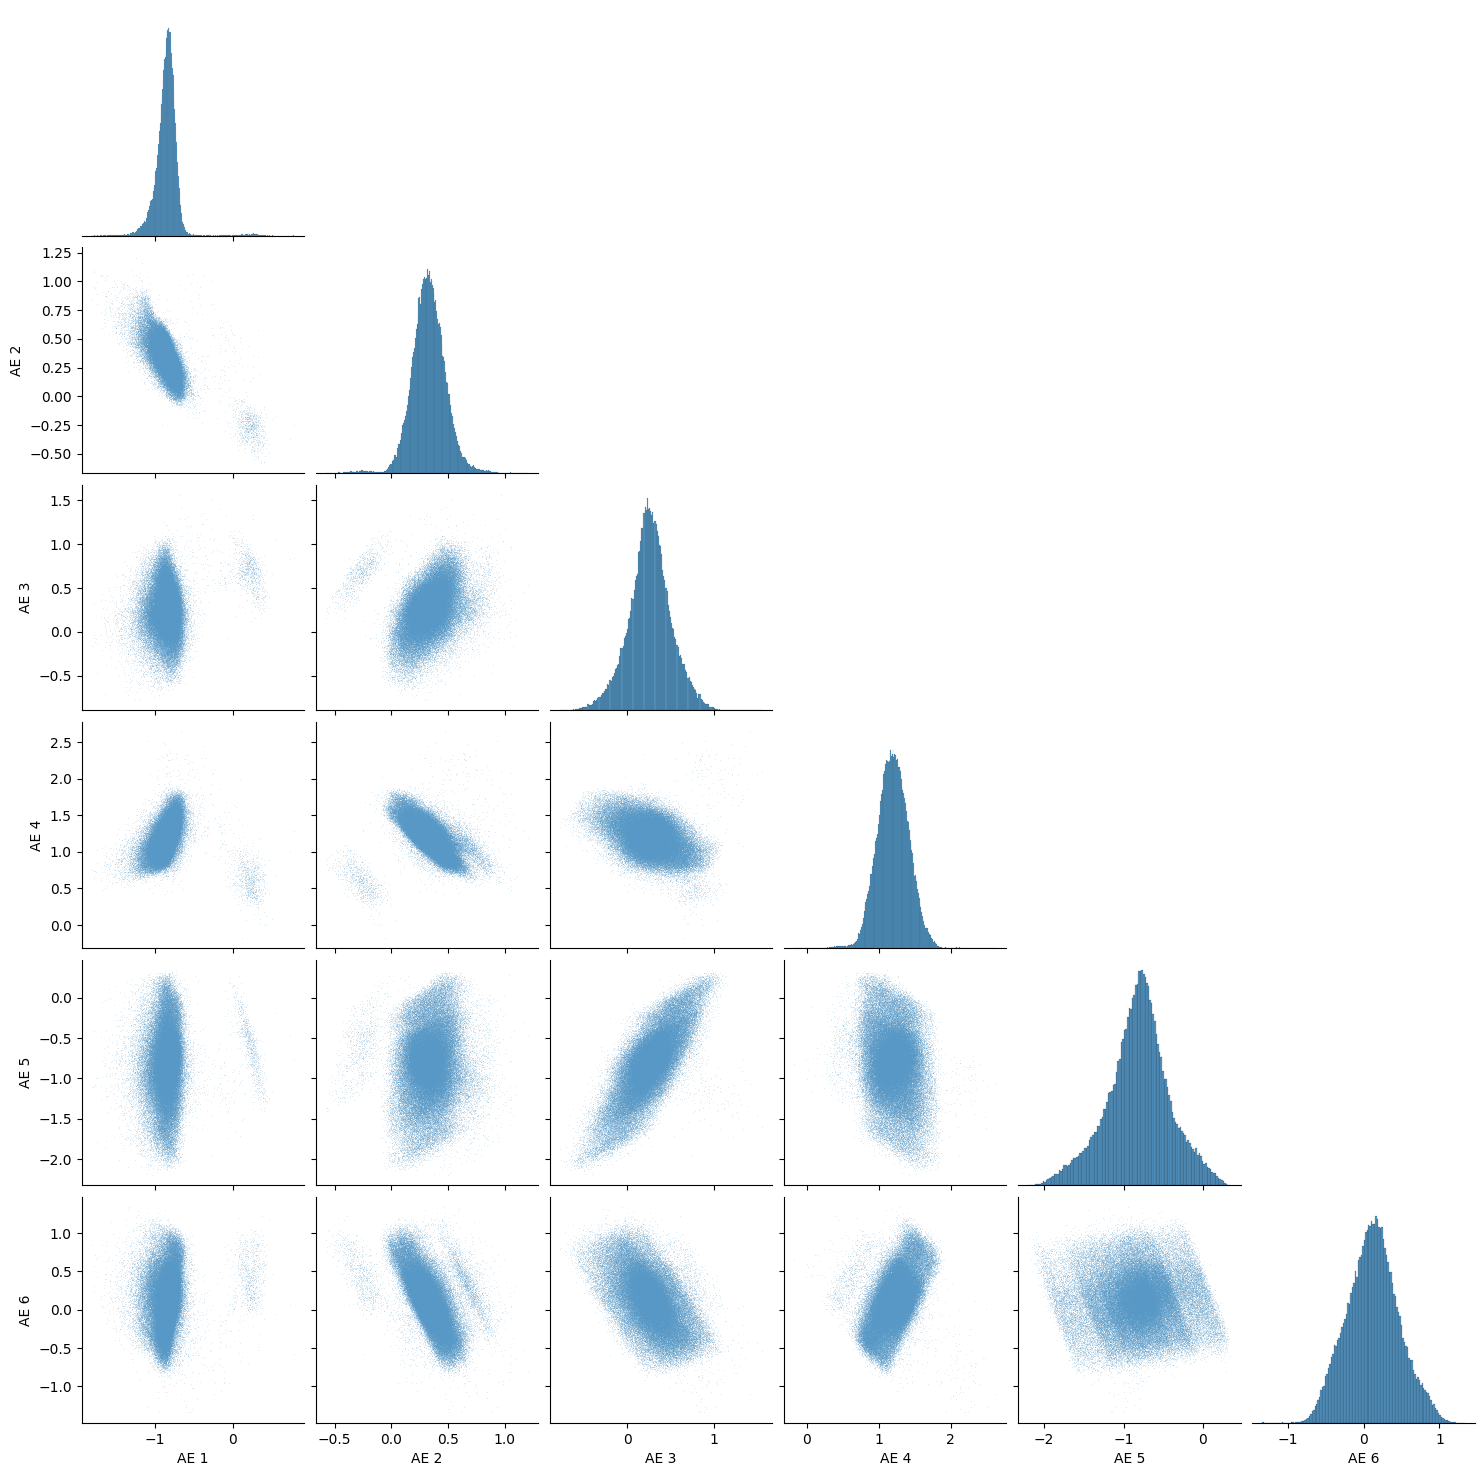

In [45]:
import seaborn as sns
g = sns.pairplot(
    pd.DataFrame(encoded[:100000], columns=[f"AE {i}" for i in range(1,7)]),
    plot_kws={"s":0.1},
    corner=True
)